<a href="https://colab.research.google.com/github/ZzzzzzT233/linearRegression/blob/main/04_hedonic_pricing/04_hedonic_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [ ]:
! git clone https://github.com/ZzzzzzT233/linearRegression

fatal: destination path 'linearRegression' already exists and is not an empty directory.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df = pd.read_csv('linearRegression/04_hedonic_pricing/airbnb_hw.csv')

print(df.dtypes, '\n')
print(df.head(),'\n')

Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                          object
Review Scores Rating          float64
dtype: object 

    Host Id Host Since                                Name Neighbourhood   \
0   5162530        NaN     1 Bedroom in Prime Williamsburg       Brooklyn   
1  33134899        NaN     Sunny, Private room in Bushwick       Brooklyn   
2  39608626        NaN                Sunny Room in Harlem      Manhattan   
3       500  6/26/2008  Gorgeous 1 BR with Private Balcony      Manhattan   
4       500  6/26/2008            Trendy Times Square Loft      Manhattan   

  Property Type  Review Sco

In [ ]:
df["Price"] = df["Price"].str.replace(",", "")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
print("Total Missings:", sum(df["Price"].isnull()),"\n")
df["Review_score_is_na"] = df["Review Scores Rating"].isnull().astype(int)
df["Review Scores Rating"] = df["Review Scores Rating"].fillna(0)


print(df.describe(), '\n')
df.head()

Total Missings: 0 

            Host Id  Review Scores Rating (bin)       Zipcode          Beds  \
count  3.047800e+04                22155.000000  30344.000000  30393.000000   
mean   1.273171e+07                   90.738659  10584.854831      1.530089   
std    1.190270e+07                    9.059519    921.299397      1.015359   
min    5.000000e+02                   20.000000   1003.000000      0.000000   
25%    2.701298e+06                   85.000000  10017.000000      1.000000   
50%    8.551693e+06                   90.000000  10065.000000      1.000000   
75%    2.120617e+07                  100.000000  11216.000000      2.000000   
max    4.303307e+07                  100.000000  99135.000000     16.000000   

       Number of Records  Number Of Reviews         Price  \
count            30478.0       30478.000000  30478.000000   
mean                 1.0          12.018735    163.589737   
std                  0.0          21.980703    197.785454   
min                  1.0

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating,Review_score_is_na
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,0.0,1
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,0.0,1
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,0.0,1
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,0.0,1
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0,0


<Axes: >

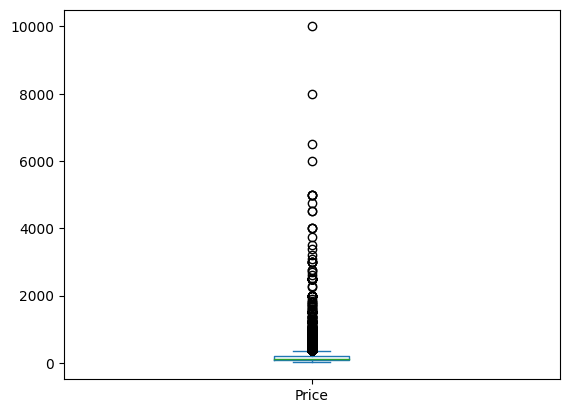

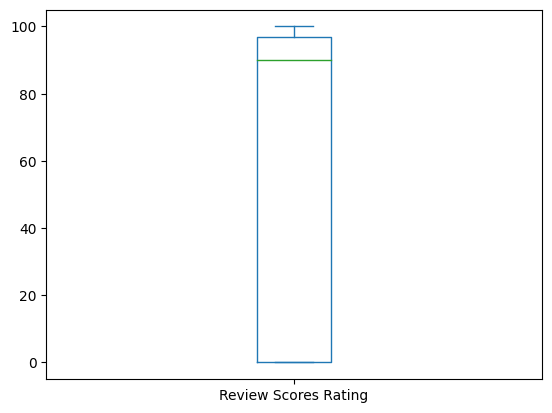

In [ ]:
def winsorize(x):
    # Convert from pd to np, if necessary:
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    # Compute IQR and 25, 75 quantiles:
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windorize x:
    x_winsor = np.copy(x)
    x_winsor[ x < lower_whisker ] = lower_whisker
    x_winsor[ x > upper_whisker ] = upper_whisker
    return(x_winsor)

df.loc[:,['Price']].plot.box()
df.loc[:,['Review Scores Rating']].plot.box()

<Axes: >

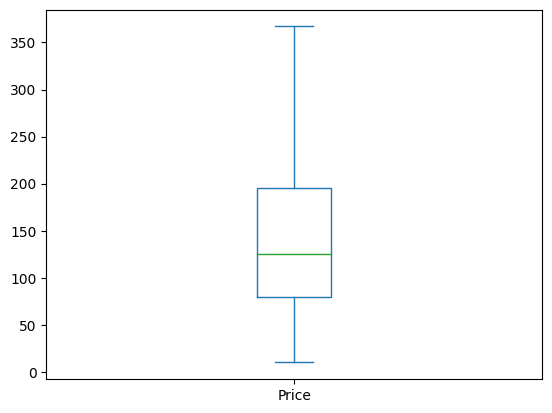

In [ ]:
df.loc[:,['Price']] = df.loc[:,['Price']].apply(winsorize)

df.loc[:,['Price']].plot.box()

In [ ]:
print(df['Room Type'].unique(),'\n')
type = df['Room Type'].replace(['Entire home/apt'],"Entire Home")
df['Room Type'] = type

print(df['Neighbourhood '].unique(),'\n')

ddf = pd.get_dummies(df[['Room Type', 'Neighbourhood ']],drop_first=False,dtype='int')
ddf.head()

['Entire home/apt' 'Private room' 'Shared room'] 

['Brooklyn' 'Manhattan' 'Queens' 'Bronx' 'Staten Island'] 



,Room Type_Entire Home,Room Type_Private room,Room Type_Shared room,Neighbourhood _Bronx,Neighbourhood _Brooklyn,Neighbourhood _Manhattan,Neighbourhood _Queens,Neighbourhood _Staten Island
0,1,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0
2,0,1,0,0,0,1,0,0
3,1,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0


In [ ]:
df = pd.concat([df, ddf], axis=1)
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,...,Review Scores Rating,Review_score_is_na,Room Type_Entire Home,Room Type_Private room,Room Type_Shared room,Neighbourhood _Bronx,Neighbourhood _Brooklyn,Neighbourhood _Manhattan,Neighbourhood _Queens,Neighbourhood _Staten Island
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire Home,11249.0,1.0,1,...,0.0,1,1,0,0,0,1,0,0,0
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,...,0.0,1,0,1,0,0,1,0,0,0
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,...,0.0,1,0,1,0,0,0,1,0,0
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire Home,10024.0,3.0,1,...,0.0,1,1,0,0,0,0,1,0,0
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,...,96.0,0,0,1,0,0,0,1,0,0


In [ ]:
y = df['Price']
X = df.drop(['Price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

In [ ]:
Z_train = X_train.loc[:,['Review Scores Rating','Review_score_is_na']]
Z_test = X_test.loc[:,['Review Scores Rating','Review_score_is_na']]

reg = LinearRegression(fit_intercept=False).fit(Z_train, y_train)
y_hat = reg.predict(Z_test)
rsq = reg.score(Z_test,y_test)
print('Rsq: ', rsq)

rmse = np.sqrt(np.mean((y_test - y_hat)**2))
print('RMSE: ', rmse)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

Rsq:  0.0038530019306097785
RMSE:  85.94092646205445


,variable,coefficient
0,Review Scores Rating,1.581542
1,Review_score_is_na,152.129738


In [ ]:
Z_train = X_train.loc[:,['Neighbourhood _Bronx','Neighbourhood _Brooklyn','Neighbourhood _Manhattan','Neighbourhood _Queens','Neighbourhood _Staten Island','Room Type_Entire Home','Room Type_Private room','Room Type_Shared room']]
Z_test = X_test.loc[:,['Neighbourhood _Bronx','Neighbourhood _Brooklyn','Neighbourhood _Manhattan','Neighbourhood _Queens','Neighbourhood _Staten Island','Room Type_Entire Home','Room Type_Private room','Room Type_Shared room']]

reg = LinearRegression(fit_intercept=False).fit(Z_train, y_train)
y_hat = reg.predict(Z_test)
rsq = reg.score(Z_test,y_test)
print('Rsq: ', rsq)

rmse = np.sqrt(np.mean((y_test - y_hat)**2))
print('RMSE: ', rmse)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

Rsq:  0.4357110434833483
RMSE:  64.68284168969657


,variable,coefficient
0,Neighbourhood _Bronx,2.000356e+14
1,Neighbourhood _Brooklyn,2.000356e+14
2,Neighbourhood _Manhattan,2.000356e+14
3,Neighbourhood _Queens,2.000356e+14
4,Neighbourhood _Staten Island,2.000356e+14
5,Room Type_Entire Home,-2.000356e+14
6,Room Type_Private room,-2.000356e+14
7,Room Type_Shared room,-2.000356e+14


In [ ]:
Z_train = X_train.loc[:,['Review Scores Rating','Review_score_is_na','Neighbourhood _Bronx','Neighbourhood _Brooklyn','Neighbourhood _Manhattan','Neighbourhood _Queens','Neighbourhood _Staten Island']]
Z_test = X_test.loc[:,['Review Scores Rating','Review_score_is_na','Neighbourhood _Bronx','Neighbourhood _Brooklyn','Neighbourhood _Manhattan','Neighbourhood _Queens','Neighbourhood _Staten Island']]

reg = LinearRegression(fit_intercept=False).fit(Z_train, y_train)
y_hat = reg.predict(Z_test)
rsq = reg.score(Z_test,y_test)
print('Rsq: ', rsq)

rmse = np.sqrt(np.mean((y_test - y_hat)**2))
print('RMSE: ', rmse)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

Rsq:  0.12905918388604176
RMSE:  80.35865106542956


,variable,coefficient
0,Review Scores Rating,0.948270
1,Review_score_is_na,94.973530
2,Neighbourhood _Bronx,-5.851745
3,Neighbourhood _Brooklyn,32.938283
4,Neighbourhood _Manhattan,85.853674
5,Neighbourhood _Queens,8.956960
6,Neighbourhood _Staten Island,19.126010


In [ ]:
y_train_ihs = np.arcsinh(y_train)
y_test_ihs = np.arcsinh(y_test)
X_train['Review Scores Rating_ihs'] = np.arcsinh(X_train['Review Scores Rating'])
X_test['Review Scores Rating_ihs'] = np.arcsinh(X_test['Review Scores Rating'])

Z_train_ihs = X_train.loc[:,['Review Scores Rating_ihs','Review_score_is_na']]
Z_test_ihs = X_test.loc[:,['Review Scores Rating_ihs','Review_score_is_na']]

reg = LinearRegression(fit_intercept=False).fit(Z_train_ihs, y_train_ihs)
y_hat = reg.predict(Z_test_ihs)
rsq = reg.score(Z_test_ihs,y_test_ihs)
print('Rsq: ', rsq)

rmse = np.sqrt(np.mean((y_test_ihs - y_hat)**2))
print('RMSE: ', rmse)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

Rsq:  0.0029901052019561947
RMSE:  0.574368862266527


,variable,coefficient
0,Review Scores Rating_ihs,1.061261
1,Review_score_is_na,5.532351


In [ ]:
Z_train_ihs = X_train.loc[:,['Review Scores Rating_ihs','Review_score_is_na','Neighbourhood _Bronx','Neighbourhood _Brooklyn','Neighbourhood _Manhattan','Neighbourhood _Queens','Neighbourhood _Staten Island']]
Z_test_ihs = X_test.loc[:,['Review Scores Rating_ihs','Review_score_is_na','Neighbourhood _Bronx','Neighbourhood _Brooklyn','Neighbourhood _Manhattan','Neighbourhood _Queens','Neighbourhood _Staten Island']]

reg = LinearRegression(fit_intercept=False).fit(Z_train_ihs, y_train_ihs)
y_hat = reg.predict(Z_test_ihs)
rsq = reg.score(Z_test_ihs,y_test_ihs)
print('Rsq: ', rsq)

rmse = np.sqrt(np.mean((y_test_ihs - y_hat)**2))
print('RMSE: ', rmse)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_})
results

Rsq:  0.15563773769617129
RMSE:  0.5285737130211466


,variable,coefficient
0,Review Scores Rating_ihs,0.520938
1,Review_score_is_na,2.729392
2,Neighbourhood _Bronx,2.265788
3,Neighbourhood _Brooklyn,2.634115
4,Neighbourhood _Manhattan,3.013118
5,Neighbourhood _Queens,2.430162
6,Neighbourhood _Staten Island,2.447618


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
expander = PolynomialFeatures(degree=3, include_bias=False)
Z_train_pol = expander.fit_transform(X_train.loc[:, ['Review Scores Rating_ihs']])
names = expander.get_feature_names_out()
Z_train_pol = pd.DataFrame(data=Z_train_pol, columns = names)
Z_train_pol = pd.concat([Z_train_pol, X_train.loc[:,['Review_score_is_na']]], axis=1)


Z_test_pol = expander.fit_transform(X_test.loc[:, ['Review Scores Rating_ihs']])
names = expander.get_feature_names_out()
Z_test_pol = pd.DataFrame(data=Z_test_pol, columns = names)
Z_test_pol = pd.concat([Z_test_pol, X_test.loc[:,['Review_score_is_na']]], axis=1)


In [ ]:
reg = LinearRegression(fit_intercept=False).fit(Z_train_pol, y_train_ihs)
y_hat_ihs = reg.predict(Z_test_pol)
rsq = reg.score(Z_test_pol,y_test_ihs)
print('Rsq: ', rsq)

rmse = np.sqrt(np.mean((y_test_ihs - y_hat_ihs)**2))
print('RMSE: ', rmse)

results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_}) # Regression coefficients
results

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
Z_train_pol = pd.concat([Z_train_pol, X_train.loc[:,['Neighbourhood _Bronx','Neighbourhood _Brooklyn','Neighbourhood _Manhattan','Neighbourhood _Queens','Neighbourhood _Staten Island']]], axis=1)
Z_test_pol = pd.concat([Z_test_pol, X_test.loc[:,['Neighbourhood _Bronx','Neighbourhood _Brooklyn','Neighbourhood _Manhattan','Neighbourhood _Queens','Neighbourhood _Staten Island']]], axis=1)

print(Z_train_pol.shape[0])
print(Z_train.shape[0])
print(X_train.shape[0])
Z_train_pol.head()

# reg = LinearRegression(fit_intercept=False).fit(Z_train_pol, y_train_ihs)
# y_hat_ihs = reg.predict(Z_test_pol)
# rsq = reg.score(Z_test_pol,y_test_ihs)
# print('Rsq: ', rsq)

# rmse = np.sqrt(np.mean((y_test_ihs - y_hat_ihs)**2))
# print('RMSE: ', rmse)

# results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_}) # Regression coefficients
# results

24086
17608
17608


,Beds_ihs,Review Scores Rating_ihs,Beds_ihs^2,Beds_ihs Review Scores Rating_ihs,Review Scores Rating_ihs^2,Beds_ihs^3,Beds_ihs^2 Review Scores Rating_ihs,Beds_ihs Review Scores Rating_ihs^2,Review Scores Rating_ihs^3,Neighbourhood _Bronx,...,Neighbourhood _Bronx,Neighbourhood _Brooklyn,Neighbourhood _Manhattan,Neighbourhood _Queens,Neighbourhood _Staten Island,Neighbourhood _Bronx,Neighbourhood _Brooklyn,Neighbourhood _Manhattan,Neighbourhood _Queens,Neighbourhood _Staten Island
0,1.443635,5.135833,2.084083,7.414271,26.376781,3.008657,10.703504,38.078457,135.466743,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.443635,5.225776,2.084083,7.544115,27.308730,3.008657,10.890952,39.423852,142.709296,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.443635,5.247052,2.084083,7.574830,27.531552,3.008657,10.935293,39.745526,144.459480,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.881374,5.298342,0.776819,4.669819,28.072432,0.684668,4.115855,24.742300,148.737355,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.881374,5.257522,0.776819,4.633841,27.641543,0.684668,4.084145,24.362526,145.326033,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


The thing I learnt from step 1 to 5 includes:

    1. I know how to handle NA values in linear regression. When trying to clean the data, I realized that there are multiple NA values in Score rating. To clean them, I first add a variable checking whether the Score rating is NA. Then I manually set all NA values in Score rating to 0. I use these two variables to perform linear regression so that I not only get the coefficient for Score rating but also the predicted price when Score rating is not provided.

    2. When I add more variables for linear regression, I realize that the coefficients for previous variables become lower. In multiple linear regression, each coefficient represents the effect of that variable while holding all other variables constant. Therefore, when an additional variable (in this case, Room Type) is introduced, the predictive power of Review Score Ratings diminish, leading to a lower coefficient value.

    3. When applying the arcsinh transformation to rescale the variables, I found that the difference between coefficients becomes smaller. By reducing outlier effects, variables no longer need larger coefficients to compensate for their wider range, which reduces the values.